# A simple working example of the BestMSM package

The following provides a minimal example to how the BestMSM package works. We construct an MSM using data from explicit water atomistic simulations of the ala5 peptide, the small molecule that you can see below.
<img src="files/ala5_nowater.png" width="200">.

### Loading the trajectory data

The first thing that you must do is to import the trajectory module from the BestMSM package.

In [1]:
import bestmsm.trajectory as traj

The only required input is the name of the file with strings corresponding to time-stamps and state names (or indexes or whatever you want; they'll be handled as strings). In the current example states look like the following:

```1 11111
2 11111
3 11111
4 11111
5 11111
6 11111
7 11111
8 11110
9 11100
...
```

These strings are just helix-coil states for the ala5 pentapeptide. Ones ("1") indicate that a residue is in the helical configuration of the Ramachandran map, while zeros ("0") correspond to the coil region (most of what we see here are fully helical states).

Then we generate an instance of the TimeSeries class

In [2]:
traj_ala5 = traj.TimeSeries("files/ala5_32states_timeseries.dat")

The TimeSeries class has a number of atributes, which we can explore. These attributes are the time stamps of the snapshots of the trajectory ('`time`'), the corresponding the states ('`states`'), and the names of the states ('`keys`'), the lag between snapshots ('`dt`') and the filename ('`filename`'). For example, in this case, the lag between snapshots is 1 unit of time (in this case, picoseconds).

In [3]:
traj_ala5.dt

1.0

### Generating an MSM

Having read one or multiple trajectories we now invoke the MasterMSM class.

In [4]:
%pylab inline 
import bestmsm.msm as msm
msm_ala5 = msm.MasterMSM([traj_ala5])

Populating the interactive namespace from numpy and matplotlib

 Building MSM from 
['files/ala5_32states_timeseries.dat']
     # states: 32


The instance of the `MasterMSM class` starts off only with the trajectories (or instances of the `trajectory` class) we created above.

In [5]:
print msm_ala5.keys

['11111', '11110', '01111', '01110', '01101', '01100', '01000', '01001', '11000', '00000', '11001', '01011', '01010', '00010', '00110', '10110', '10111', '10100', '10101', '10001', '10000', '10010', '00111', '11101', '00101', '00100', '00011', '10011', '11011', '11100', '00001', '11010']


For multiple files, MasterMSM will merge the keys from the different trajectories and make a common set. Alternatively, one can provide the list of states to be considered. This option may be useful in different situations. For example, we may want states to be ordered in a predefined way. Or we may want to entirely disregard states that we know are very rarely populated. In this case, the instance of the MasterMSM class would be generated in the following way.

In [6]:
msm_ala5 = msm.MasterMSM([traj_ala5], filekeys="files/states")
nstates = len(msm_ala5.keys)


 Building MSM from 
['files/ala5_32states_timeseries.dat']
     # states: 32


This way we have given a list of 32 states which are sorted by the number of helical residues. You can check that the states are ordered so that the first few are mostly coil and the last few are fully helical. This may turn out to be more convenient in this case.

In [7]:
print msm_ala5.keys 

['00000', '00001', '00010', '10000', '00100', '01000', '10001', '00110', '01001', '00011', '10010', '10100', '00101', '11000', '01010', '01100', '10011', '01011', '01101', '10101', '10110', '11001', '01110', '00111', '11010', '11100', '01111', '10111', '11110', '11011', '11101', '11111']


###Calculating interesting stuff

Now that you have generated your MSM, you can start computing interesting things. You probably want to generate a count matrix, a transition matrix and a rate matrix, and possibly derive relaxation times and equilibrium probabilities from them. In order to do this, we generate an instance of the `MSM` class. The way things are organized in BestMSM, you may never have to deal with the MSM class directly. Everything can be orchestrated from `MasterMSM`.

So what we do is to generate the MSM for a given lag time using the data loaded before. Here we naively choose 5 picoseconds

In [8]:
msm_ala5.do_msm(5)

When invoking the `do_msm` method a lot of stuff has happened under the hood. First, a transition count matrix has been computed, and then the connectivity of that matrix has been checked. Finally, the transition matrix and its eigenvalues and eigenvectors have been produced. Below you can find plots of the eigenvalues and eigenvectors of the transition matrix.

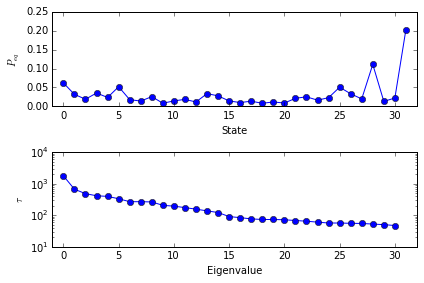

In [9]:
fig, axarr = plt.subplots(2)
axarr[0].plot(msm_ala5.msms[5].peqT, 'o-')
axarr[0].set_xlabel(r'State')
axarr[0].set_ylabel(r'$P_{eq}$')
axarr[0].set_xlim([-1,32])
axarr[1].semilogy(msm_ala5.msms[5].tauT, 'o-')
axarr[1].set_xlim([-1,32])
axarr[1].set_xlabel(r'Eigenvalue')
axarr[1].set_ylabel(r'$\tau$')
fig.tight_layout()
plt.show()



Here we are of course looking at the equilibrium probabilities of all the states (top panel, with the indexes corresponding to the indexes of the `keys`) and at the relaxation times of the system, sorted from slow to fast.

###Chapman-Kolmogorov tests

Although the example above gives some idea of the available functionalitites, you may want to start finding out which lag time is a sensible choice for your system. In order to do that, you want to know the dependence of your model with respect to the lag time used to construct it. In order to identify the right lag time, we usually look at the convergence of certain properties as a function of the lag time.

One of the first tests is the dependence of the relaxation times with the lag time used to compute the transition count matrix. This test is readily available in the MasterMSM class.


 Convergence test for the MSM: looking at implied timescales

    Generating MSM at lag time: 1

    Generating MSM at lag time: 25

    Generating MSM at lag time: 50

    Generating MSM at lag time: 75

    Generating MSM at lag time: 100

    Generating MSM at lag time: 125

    Generating MSM at lag time: 150

    Generating MSM at lag time: 175

    Generating MSM at lag time: 200


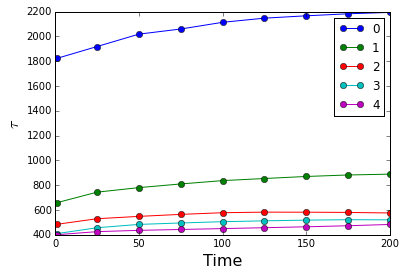

In [11]:
msm_ala5.convergence_test(plot=True, N=5, error=False, sliding=True)

As you can see, all we are doing is to construct the MSM at different values of the lag time and then plotting the dependence of the relaxation times with the lag. The options we have introduced are `plot=True` and `N=5`, for plotting the 5 slowest eigenmodes after the calculation is done, and `sliding=True` for the sliding window method to be used in the estimation of transition count matrices (see documentation). In the plot the different colours correspond to different eigenvalues. In this case, the dependence of the relaxation times is pretty flat, suggesting the results are well converged even at low lag times. This suggests that the Markov assumption is acceptable. For simplicity we have not calculated errors but these should be included for properly identifying the right lag time to use.

The other usual convergence test for MSMs is an explicit comparison between the simulation data and the model predictions (this test is, in fact, usually called the Chapman-Kolmogorov test). In order to do this, one simulates the relaxation of population from a state or set of states and compares the decay of the population with the actual result from the transition count matrix. This test is also available in BestMSM.


 Chapman - Kolmogorov test:

    Initial states ['11111', '11110', '01111', '11100']

    Calculating relaxation from MSM

    Calculating populations from MD


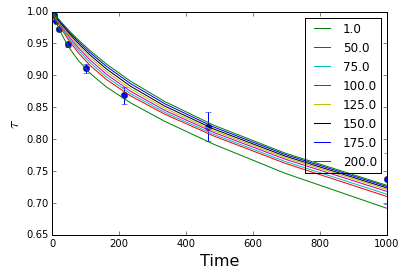

In [12]:
msm_ala5.chapman_kolmogorov(init=['11111', '11110', '01111', '11100'], sliding=True, plot=True)

Here we are relaxing from a set of structured states, with at least three consecutive helical residues (`111`). What we see as circles is the result from the simulation data and as lines we show the results for a given range of lag times. It can be seen that all but maybe the shortest lag time (green line) agree well with the simulation data.

###Error estimation

After carrying out this test, you usually choose a lag time for which the MSM seems well converged and then move ahead with the analysis. In our case we are going to use the MSM at a lag time of 5. The MSM at different lag times can be accessed from the MasterMSM instance very simply:

In [14]:
msm_ala5.do_msm(50)
msm_ala5.msms[50].do_rate()

One thing we can do very simply for this MSM is to calculate errors, which is done in our case using a bootstrapping method.

In [14]:
tau_ave, tau_std, peq_ave, peq_std = msm_ala5.msms[50].boots(nboots=100)

     Number of trajectories: 16
     Median of trajectory length: 25000
     ...doing bootstrap analysis
     ...running on 4 processors


Depending on the number of available processors, this may take some time. The number of bootstrap samples can be defined by the user, as well as whether results are being plotted. Now we can plot the results with error bars.

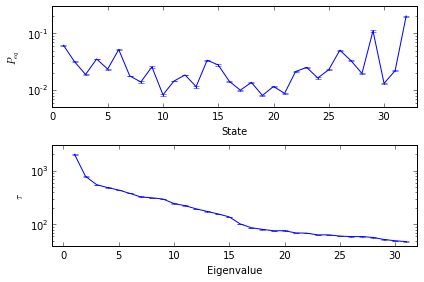

In [15]:
fig, axarr = plt.subplots(2)
axarr[0].errorbar(range(1,33),msm_ala5.msms[50].peqT, \
                  yerr=peq_std)
axarr[0].set_xlabel(r'State')
axarr[0].set_ylabel(r'$P_{eq}$')
axarr[0].set_xlim([0,33])
axarr[0].set_yscale("log", nonposy='clip')
axarr[0].set_ylim([5e-3,3e-1])

axarr[1].errorbar(range(1,32),msm_ala5.msms[50].tauT, yerr=tau_std, fmt='-')
axarr[1].set_xlim([-1,32])
axarr[1].set_yscale("log", nonposy='clip')
axarr[1].set_ylim([40,3e3])
axarr[1].set_xlabel(r'Eigenvalue')
axarr[1].set_ylabel(r'$\tau$')
fig.tight_layout()
plt.show()


###Propagation of the dynamics
One thing I find particularly cool from MSMs is the possibility of simulating the relaxation of the system from an initial condition to the equilibrium distribution. This is akin to what experimentalists do in temperature jump experiments. In BestMSM this type of relaxation is implemented in the `propagateK` method, which we have actually used already in the Chapman-Kolmogorov tests. It works like this:

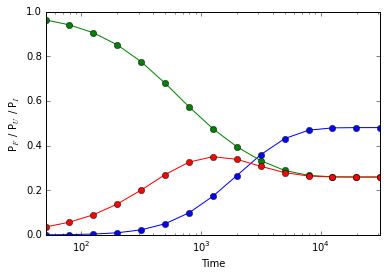

In [15]:
time, popul = msm_ala5.msms[50].propagateK(init=['00000'])
folded = [msm_ala5.keys.index(x) for x in msm_ala5.keys if '111' in x]
unfolded = [msm_ala5.keys.index(x) for x in msm_ala5.keys if '000' in x]
fu = folded + unfolded
inter = [x for x in range(nstates) if x not in fu]
popf = [np.sum([p[x] for x in folded]) for p in popul]
popu = [np.sum([p[x] for x in unfolded]) for p in popul]
popi = [np.sum([p[x] for x in inter]) for p in popul]
fig, ax = plt.subplots(1)
ax.semilogx(time, popf, 'o-')
ax.semilogx(time, popu, 'o-')
ax.semilogx(time, popi, 'o-')

ax.set_xlabel(r'Time')
ax.set_ylabel(r'P$_F$ / P$_U$ / P$_I$')
ax.set_xlim([time[0],time[-1]/10])
plt.show()

What we see here is the gradual decay of species which are in the unfolded state (in green) and the gradual increase of folded species (in blue) when we relax from state `00000` to the equilibrium. This occurs via a number of intermediate species (in red), first increasing, and then decreasing a bit to their equilibrium population.

###Committors and fluxes

Another usual result we are interested in is the values of the pfold or committor, or the folding rates from one set of microstates (UU) to another set of microstates (FF). In order to do this calculation we use the Berezhkovskii-Hummer-Szabo method ([J Chem Phys, 2009](http://scitation.aip.org/content/aip/journal/jcp/130/20/10.1063/1.3139063)). In BestMSM, we do the calculation as:

In [19]:
folded = [x for x in msm_ala5.keys if '1111' in x]
unfolded = [x for x in msm_ala5.keys if '0000' in x]
J, pfold, sumflux, kf = msm_ala5.msms[50].do_pfold(FF=folded,\
                                          UU=unfolded)
print 'Folding time: %g'%(1./kf)

   definitely FF and UU states [0, 1, 3, 26, 28, 31]
Folding time: 8131.61


###PCCA clustering

The time-scale separation between modes can be exploited to generate more intuitive models where each individual state is formed by a cluster of microstates. To perform this clustering we import another module.

In [ ]:
import bestmsm.pcca import PCCA